In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
from datetime import date
from datetime import datetime
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns




%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")
aapl?



### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

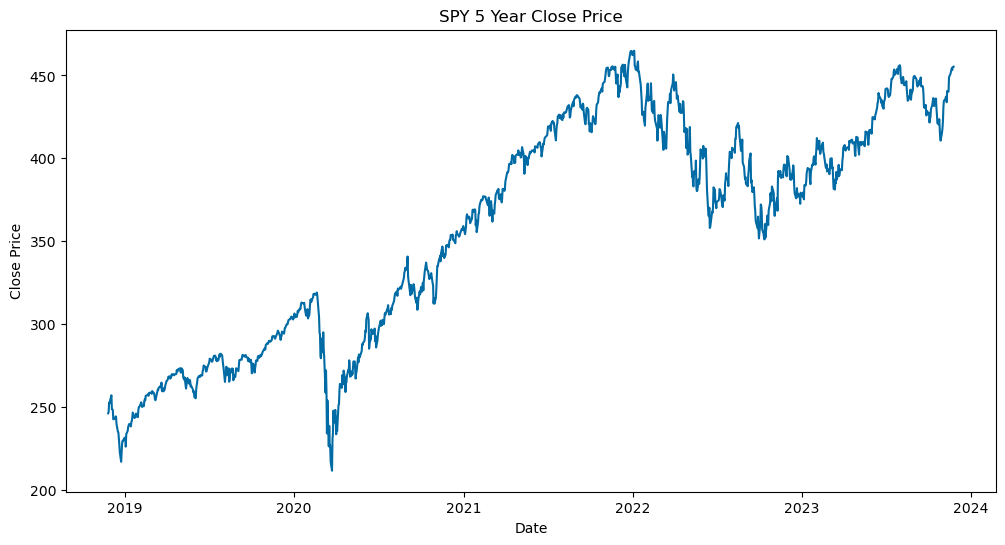

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=301.400844, mean2=415.338846, mean_percent_diff=37.802814
variance1=2070.382466, variance2=684.055033, var_percent_diff=-66.959968


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.345155
p-value: 0.608269
Critical Values:
{'1%': -3.4356006420838963, '5%': -2.8638586845641063, '10%': -2.5680044958343604}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.7000668288865, 0.01, 21, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.70
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rkartawi\AppData\Local\Temp\ipykernel_9440\2395884048.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(X)


##### P-value < .05; therefore, not stationary

### Transform into stationary series

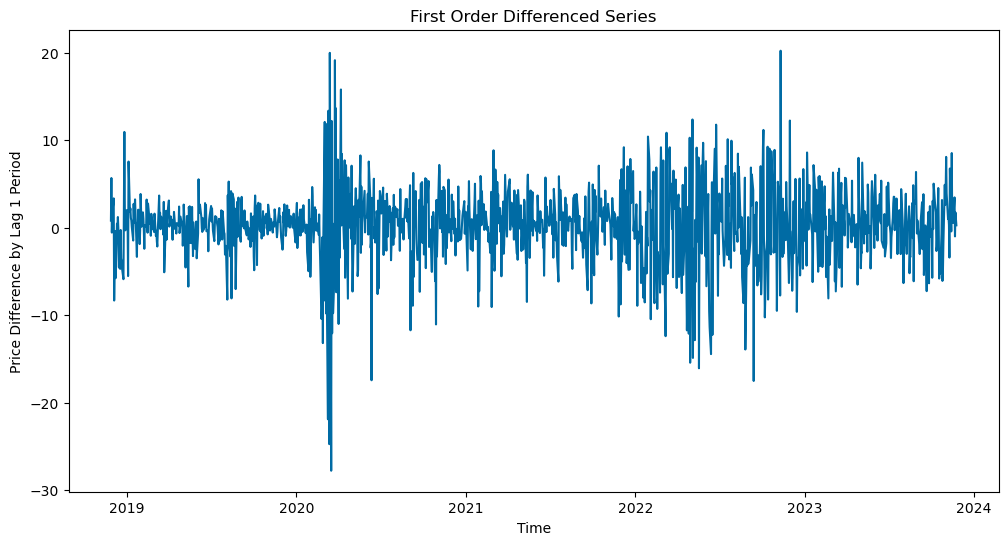

In [8]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14) 
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [9]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.789068
p-value: 0.000000
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [12]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

Time Series Evaluation Metrics
MSE = 1115.5927539599502
MAE = 27.162461160975404
RMSE = 33.400490325142684
MAPE = 0.06285612700948899
r2 = -1.1348072076432723



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


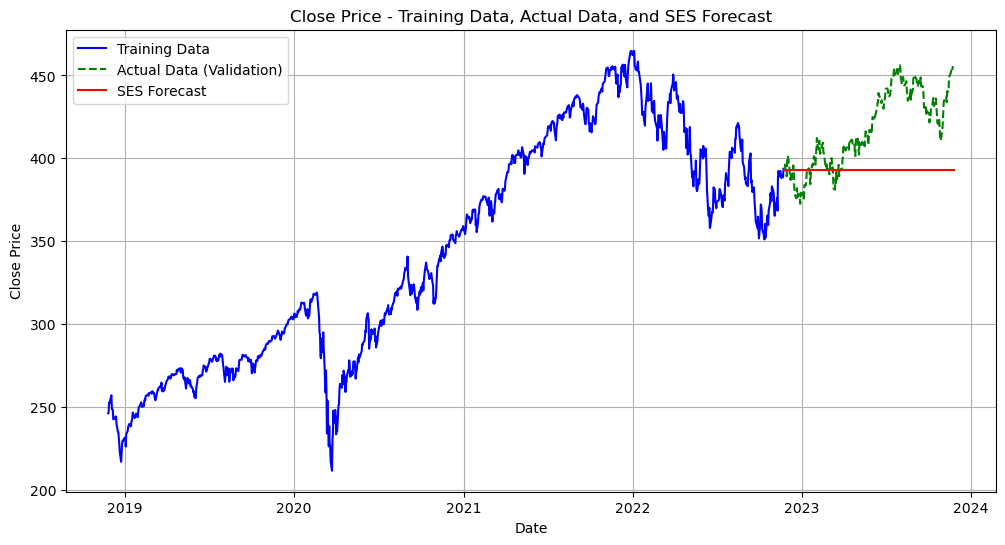

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

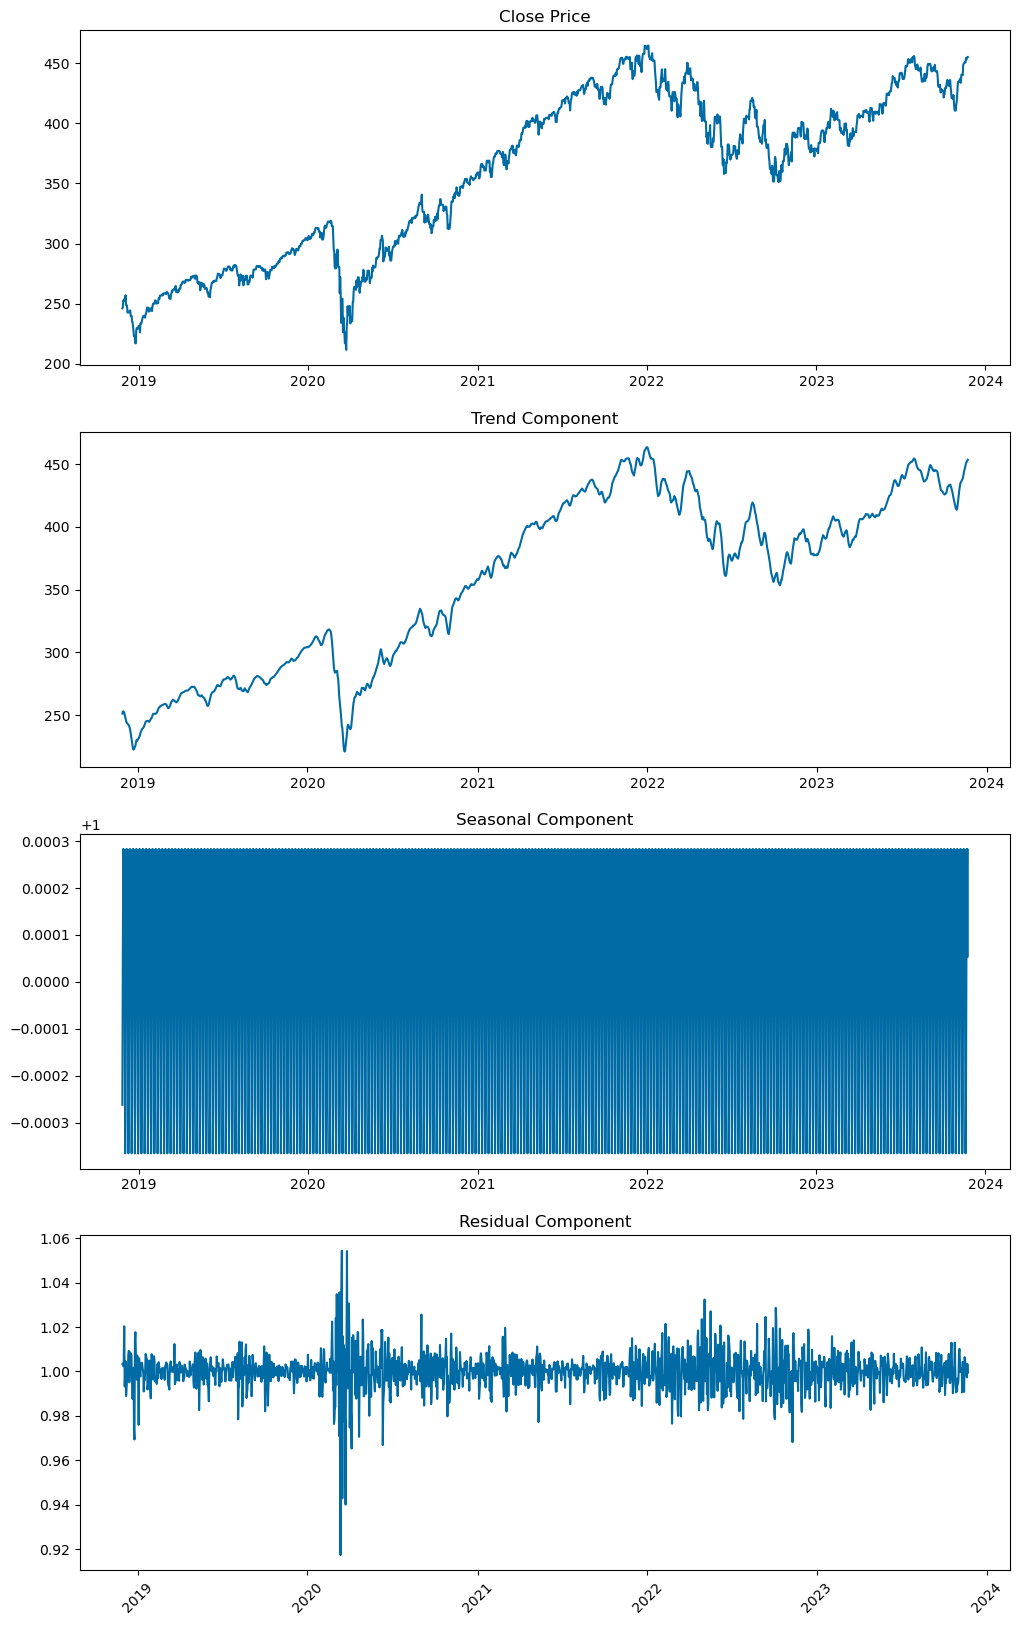

In [16]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

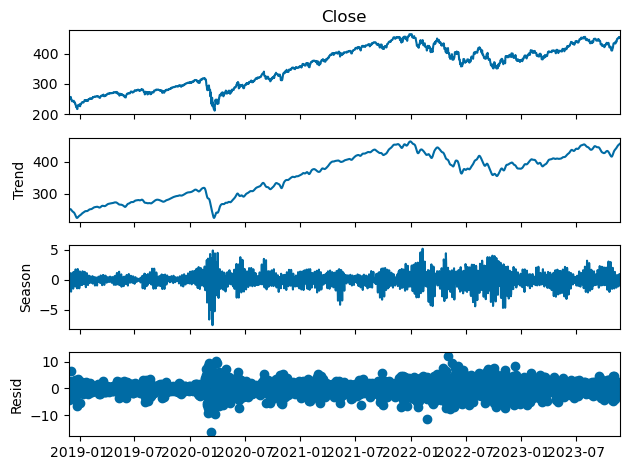

In [17]:
stl = STL(close).fit().plot()


### Autocorrelation - Raw Values

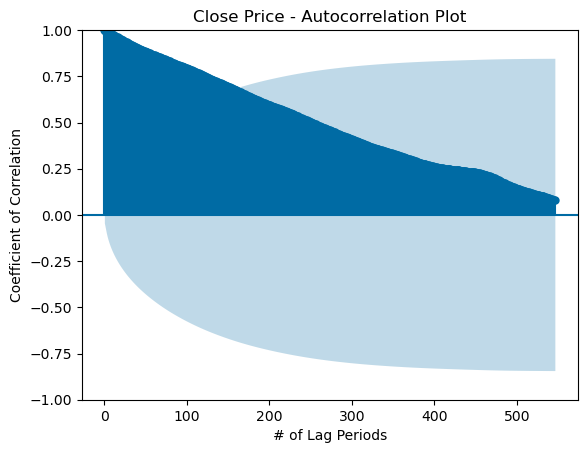

In [18]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

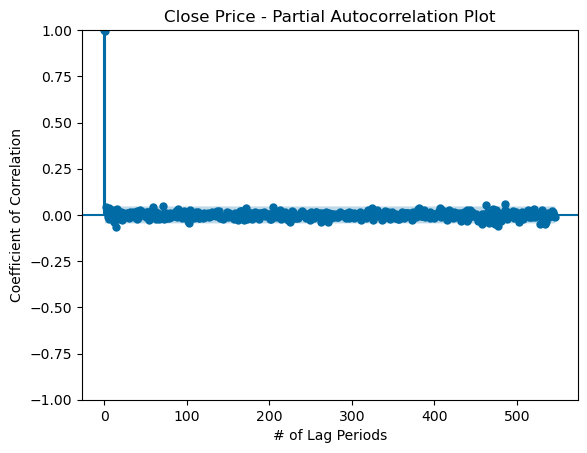

In [19]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

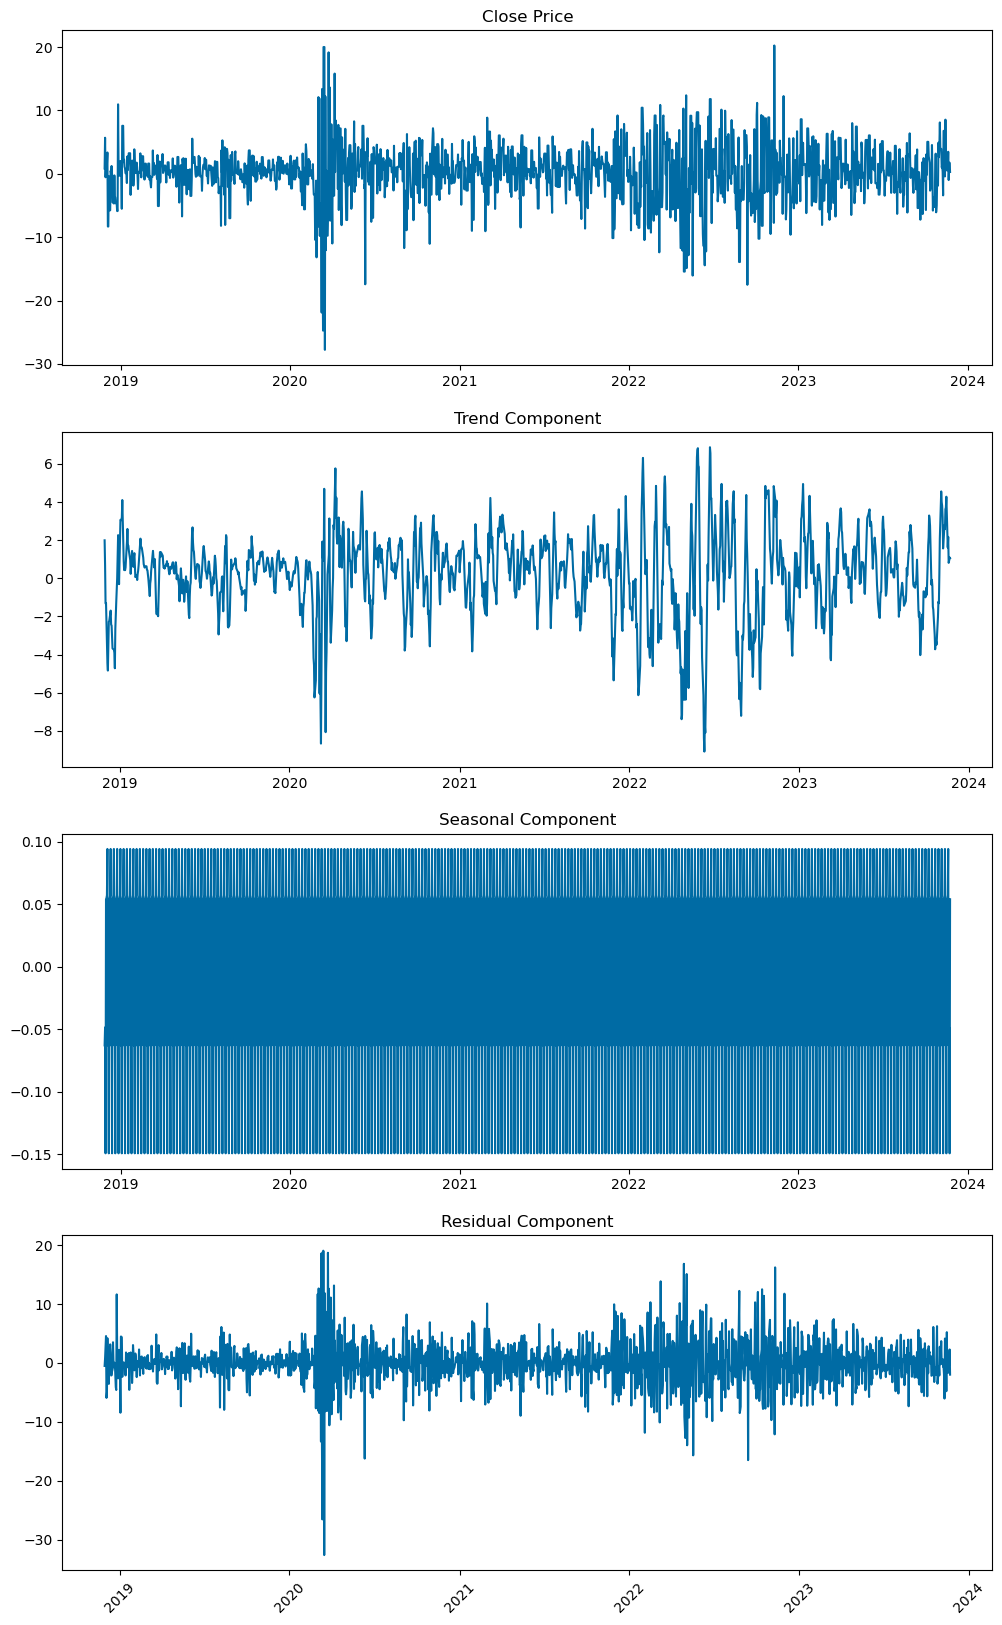

In [20]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

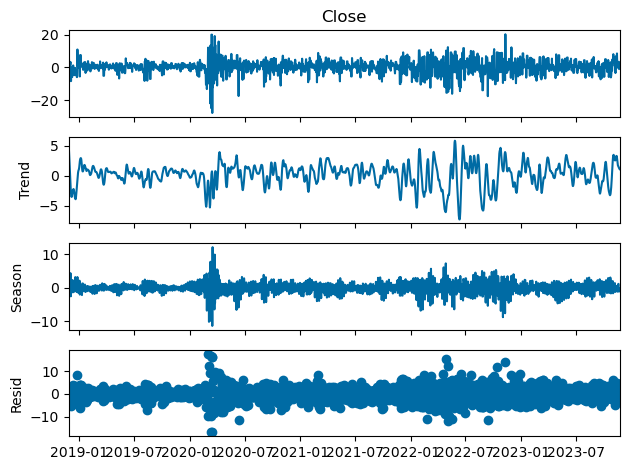

In [21]:
stl = STL(ts_lag_1).fit().plot()


# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29

### ACF on lag_1 period

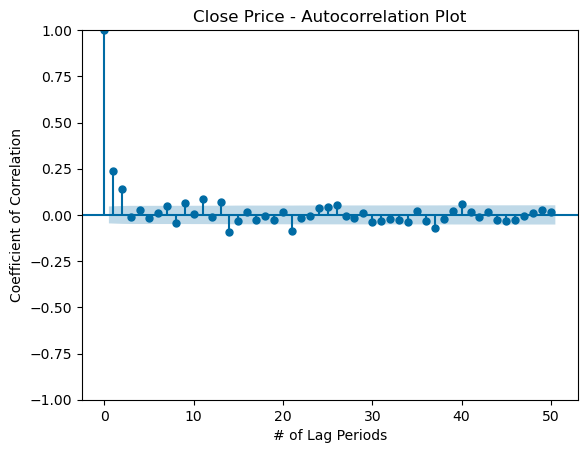

In [22]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

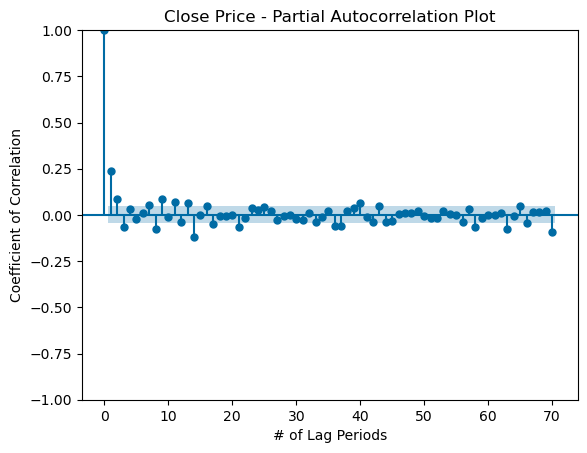

In [23]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

In [24]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC for AR(1): 10447.924424469147
BIC for AR(1): 10464.449140793184


AIC for AR(2): 10436.190595307717
BIC for AR(2): 10458.223550406432


AIC for AR(3): 10430.963677342539
BIC for AR(3): 10458.504871215933


AIC for AR(8): 10423.026951581092
BIC for AR(8): 10478.109339327879


AIC for AR(9): 10411.262183500861
BIC for AR(9): 10471.852810022327


AIC for AR(11): 10406.256777125474
BIC for AR(11): 10477.863881196297


AIC for AR(14): 10375.404321534199
BIC for AR(14): 10463.536141929058


AIC for AR(21): 10372.975176356265
BIC for AR(21): 10499.664668173875




### Select AR(14) due to lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

In [25]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkartawi\AppData\L

AIC for MA(0): 10480.599889109428
BIC for MA(0): 10563.223470729608


AIC for MA(1): 10375.404321534199
BIC for MA(1): 10463.536141929058


AIC for MA(2): 10404.853532080648
BIC for MA(2): 10498.493591250184


AIC for MA(11): 10366.846749558132
BIC for MA(11): 10510.060957699778


AIC for MA(13): 10361.285613284497
BIC for MA(13): 10515.516298975499


AIC for MA(14): 10366.425864433511
BIC for MA(14): 10526.164788899192


AIC for MA(21): 10369.477263181889
BIC for MA(21): 10567.773859070321


AIC for MA(37): 10359.321176325651
BIC for MA(37): 10645.749592608941


AIC for MA(40): 10362.237489514006
BIC for MA(40): 10665.190622121332




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [26]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA

arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Time Series Evaluation Metrics
MSE = 174709.689554283
MAE = 417.35757647971195
RMSE = 417.98288189145137
MAPE = 0.9995167228482102
r2 = -333.3258578739312



### Interpretation: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [27]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [28]:
#close_train.index

In [29]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [30]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal Period 2
AIC = 3549.792561616477
BIC = 3584.188723071095
Time Series Evaluation Metrics
MSE = 1244.3242700620885
MAE = 28.930245274352576
RMSE = 35.274980794638125
MAPE = 0.06695255142252017
r2 = -1.3811488654303012

Results for Seasonal Period 3
AIC = 3860.4296707569583
BIC = 3899.739569562236
Time Series Evaluation Metrics
MSE = 1199.0983126210074
MAE = 28.284230195622477
RMSE = 34.627998969345704
MAPE = 0.06544602785368077
r2 = -1.2946041119124292



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

Results for Seasonal Period 8
AIC = 4433.195873851168
BIC = 4497.074459409743
Time Series Evaluation Metrics
MSE = 1843.4892854350107
MAE = 40.41491572994767
RMSE = 42.93587410819781
MAPE = 0.09707588420855694
r2 = -2.5277158262190467

Results for Seasonal Period 9
AIC = 4450.244027982373
BIC = 4519.036350891609
Time Series Evaluation Metrics
MSE = 3365.875650372298
MAE = 54.842742100065614
RMSE = 58.01616714651441
MAPE = 0.1310970544442918
r2 = -5.440966538138458

Results for Seasonal Period 11
AIC = 4539.53378242743
BIC = 4618.153580037985
Time Series Evaluation Metrics
MSE = 3925.337708156122
MAE = 59.33458500955785
RMSE = 62.652515577238574
MAPE = 0.14156886992220943
r2 = -6.511557602055248

Results for Seasonal Period 14
AIC = 4582.367039073839
BIC = 4675.728048736373
Time Series Evaluation Metrics
MSE = 6667.9108656899125
MAE = 77.12120426067506
RMSE = 81.65727686917997
MAPE = 0.18338869694998555
r2 = -11.759767509666654

Results for Seasonal Period 21
AIC = 4414.428335175234
BIC

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

Time Series Evaluation Metrics
MSE = 1136.2603284966026
MAE = 27.484059589846048
RMSE = 33.708460785040344
MAPE = 0.06360292667480744
r2 = -1.174356843412002

Results for Seasonal Period 58
AIC = 4549.229809957272
BIC = 4858.795263048832
Time Series Evaluation Metrics
MSE = 938.0372942926518
MAE = 25.41585078319364
RMSE = 30.627394507085512
MAPE = 0.05913821039106002
r2 = -0.795035661343169

Results for Seasonal Period 59
AIC = 4799.582468469443
BIC = 5114.061658911663
Time Series Evaluation Metrics
MSE = 10921.108790599554
MAE = 98.20803644758413
RMSE = 104.50410896514813
MAPE = 0.23289261932366145
r2 = -19.898721042127907

Results for Seasonal Period 60
AIC = 4797.4393106377265
BIC = 5116.832238430606
Time Series Evaluation Metrics
MSE = 4068.6828558177053
MAE = 59.84437079697422
RMSE = 63.78622779109692
MAPE = 0.14249118381074022
r2 = -6.785864021958387

Results for Seasonal Period 61
AIC = 4767.26890807537
BIC = 5091.575573218909
Time Series Evaluation Metrics
MSE = 3743.2973432626

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

Results for Seasonal Period 63
AIC = 4539.785507786401
BIC = 4873.919647631259
Time Series Evaluation Metrics
MSE = 1249.0585596949775
MAE = 28.768290841528035
RMSE = 35.342022575044815
MAPE = 0.0665556465024663
r2 = -1.3902084398991086

Results for Seasonal Period 64
AIC = 4730.2090517523
BIC = 5069.256928947819
Time Series Evaluation Metrics
MSE = 6610.535433634042
MAE = 76.35073755412563
RMSE = 81.30519930259099
MAPE = 0.18130226217675366
r2 = -11.649973424450755

Results for Seasonal Period 65
AIC = 4725.668843061297
BIC = 5069.630457607474
Time Series Evaluation Metrics
MSE = 3066.5009861221993
MAE = 51.9721302509146
RMSE = 55.37599647972215
MAPE = 0.12399024176871873
r2 = -4.868080788604592

Results for Seasonal Period 70
AIC = 4789.4844525988765
BIC = 5158.014753898353
Time Series Evaluation Metrics
MSE = 11609.535869277386
MAE = 101.3246546009574
RMSE = 107.74755621023331
MAPE = 0.24034447873203627
r2 = -21.216100600467165



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer 

### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [31]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3898.024668088437
BIC = 3932.420829543055
Time Series Evaluation Metrics
MSE = 714.342844760282
MAE = 21.693926387924645
RMSE = 26.72719298318254
MAPE = 0.05190786672180113
r2 = -0.36697217538345184

Results for Seasonal mul
AIC = 3895.7168755492457
BIC = 3930.1130370038636
Time Series Evaluation Metrics
MSE = 849.3477575012413
MAE = 23.9690195247481
RMSE = 29.143571460979885
MAPE = 0.05722433742470377
r2 = -0.625318655103414

Results for Seasonal additive
AIC = 3898.024668088437
BIC = 3932.420829543055
Time Series Evaluation Metrics
MSE = 714.342844760282
MAE = 21.693926387924645
RMSE = 26.72719298318254
MAPE = 0.05190786672180113
r2 = -0.36697217538345184

Results for Seasonal multiplicative
AIC = 3895.7168755492457
BIC = 3930.1130370038636
Time Series Evaluation Metrics
MSE = 849.3477575012413
MAE = 23.9690195247481
RMSE = 29.143571460979885
MAPE = 0.05722433742470377
r2 = -0.625318655103414

Results for Seasonal None
AIC = 4639.411524467092
BIC = 4659

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

### Validation statistics suggest additive seasonality is optimal

### Searching for ideal trend parameter

In [32]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

Results for Trend add
AIC = 3860.3661897641373
BIC = 3899.676088569415
Time Series Evaluation Metrics
MSE = 1218.339669696779
MAE = 28.548632379603838
RMSE = 34.90472274201271
MAPE = 0.06606050437615245
r2 = -1.3314245265524383

Results for Trend mul
AIC = 3907.531249999429
BIC = 3946.8411488047063
Time Series Evaluation Metrics
MSE = 175.45360187958286
MAE = 11.179370054439008
RMSE = 13.245889999527508
MAPE = 0.02682785333795045
r2 = 0.6642505855564624

Results for Trend additive
AIC = 3860.3661897641373
BIC = 3899.676088569415
Time Series Evaluation Metrics
MSE = 1218.339669696779
MAE = 28.548632379603838
RMSE = 34.90472274201271
MAPE = 0.06606050437615245
r2 = -1.3314245265524383

Results for Trend multiplicative
AIC = 3907.531249999429
BIC = 3946.8411488047063
Time Series Evaluation Metrics
MSE = 175.45360187958286
MAE = 11.179370054439008
RMSE = 13.245889999527508
MAPE = 0.02682785333795045
r2 = 0.6642505855564624



ValueError: Can only dampen the trend component

### Validation statistics suggest multiplicative trend is optimal

### Searching for ideal aes_param_damped_trend parameter

In [33]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3888.8383566783987
BIC = 3928.148255483676
Time Series Evaluation Metrics
MSE = 248.03860845528172
MAE = 13.11506012561506
RMSE = 15.749241519999677
MAPE = 0.031130654900405844
r2 = 0.5253513370138361

Results for Damped Trend False
AIC = 3898.024405214153
BIC = 3932.420566668771
Time Series Evaluation Metrics
MSE = 714.3379585076585
MAE = 21.693840558680897
RMSE = 26.72710157326564
MAPE = 0.05190766582450582
r2 = -0.3669628250113901



C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [34]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3908.475892077729
BIC = 3942.872053532347
Time Series Evaluation Metrics
MSE = 351.3320487026527
MAE = 15.036771702693398
RMSE = 18.743853624659277
MAPE = 0.036317085416174504
r2 = 0.32768818443452696

Results for Initialization Method estimated
AIC = 3897.096604679759
BIC = 3931.492766134377
Time Series Evaluation Metrics
MSE = 374.2809106904214
MAE = 15.549565728532594
RMSE = 19.34634101556213
MAPE = 0.037534061954956885
r2 = 0.2837730587716919

Results for Initialization Method heuristic
AIC = 3901.339038607441
BIC = 3935.735200062059
Time Series Evaluation Metrics
MSE = 379.70721190219786
MAE = 15.66772745745152
RMSE = 19.486077386231376
MAPE = 0.03781434645558583
r2 = 0.2733892454163036

Results for Initialization Method legacy-heuristic
AIC = 3908.475892077729
BIC = 3942.872053532347
Time Series Evaluation Metrics
MSE = 351.3320487026527
MAE = 15.036771702693398
RMSE = 18.743853624659277
MAPE = 0.036317085416174504
r2 = 0.3276881844345

C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [35]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3893.1938824691
BIC = 3932.5037812743776
Time Series Evaluation Metrics
MSE = 199.4643859810313
MAE = 11.834353576239652
RMSE = 14.123186112950268
MAPE = 0.028831735673729396
r2 = 0.6183033572520567

None


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


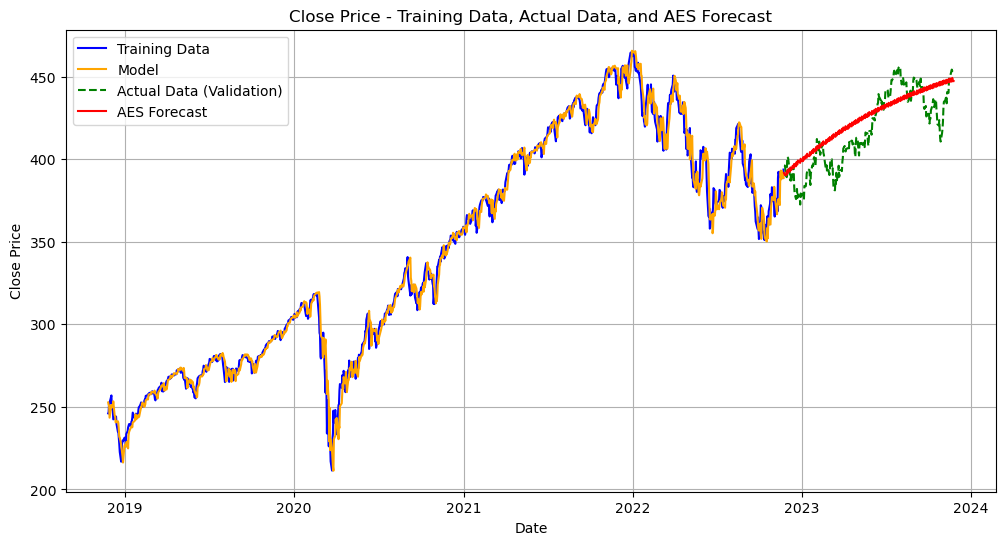

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [37]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3565.9683612330678
BIC = 3600.3645226876856
Time Series Evaluation Metrics
MSE = 348.01530773103076
MAE = 14.687624247372009
RMSE = 18.655168391923745
MAPE = 0.0342373463659236
r2 = 0.33403512645881916

None


C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rkartawi\AppData\Local\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


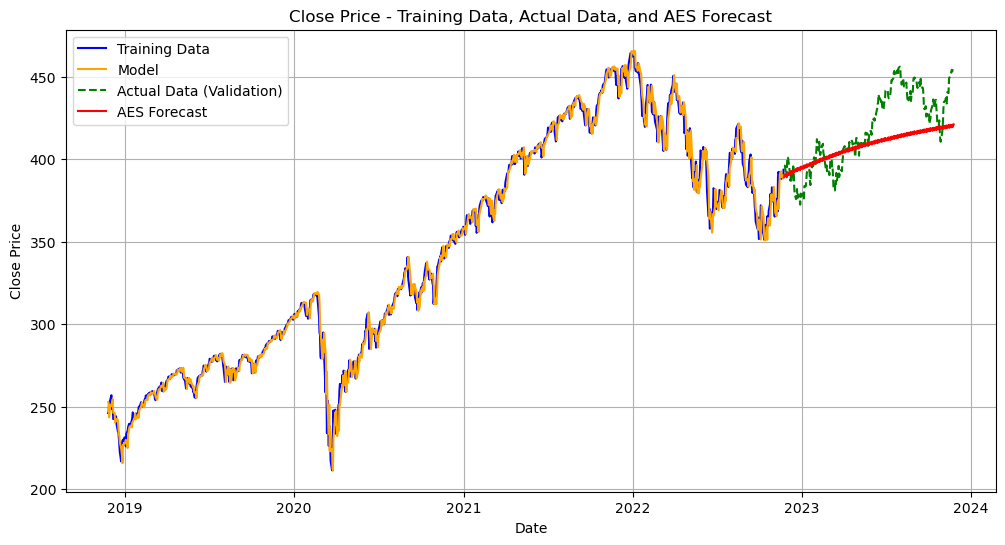

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [39]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,0)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1458
Model:                ARIMA(14, 1, 0)   Log Likelihood               -2939.926
Date:                Sat, 25 Nov 2023   AIC                           5909.852
Time:                        10:23:44   BIC                           5989.114
Sample:                    11-26-2018   HQIC                          5939.423
                         - 11-22-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1354      0.032     -4.297      0.000      -0.197      -0.074
ar.L2         -0.1104      0.031     -3.524      0.000      -0.172      -0.049
ar.L3          0.2001      0.033      6.033      0.0

In [40]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

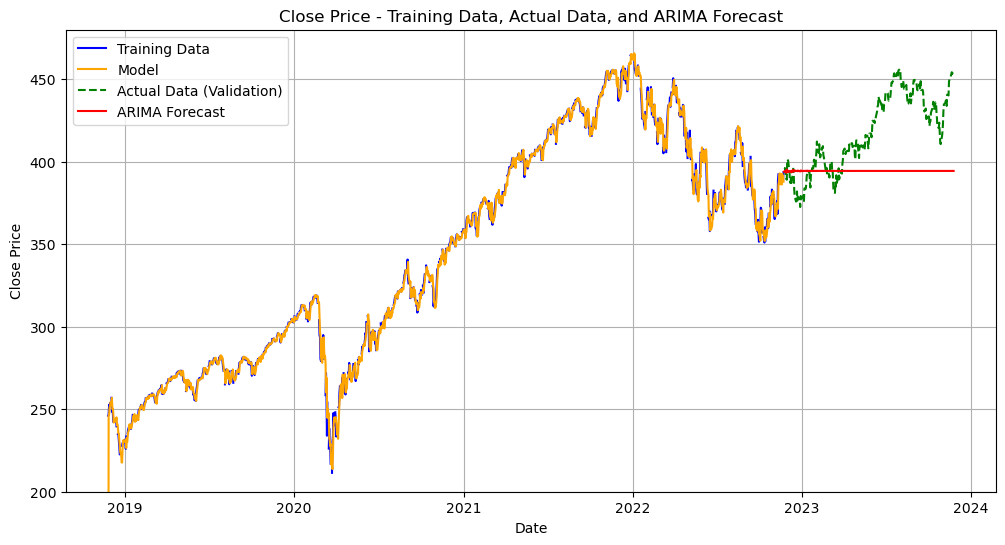

In [41]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Binary Field on positive/ negative of Open - Close

#### Logistic Regression

lag: 1, diff: 1
Accuracy: 65.31%
Sensitivity: 0.70
Specificity: 0.62


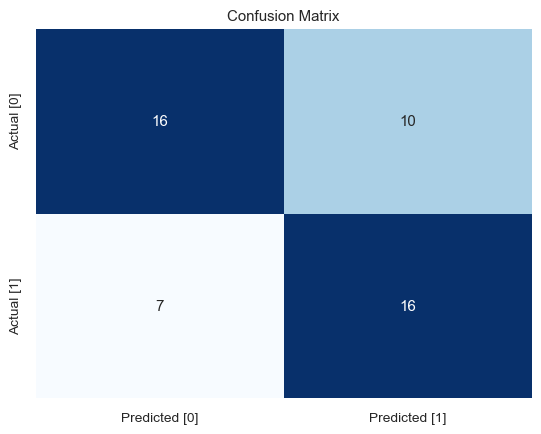

lag: 2, diff: 2
Accuracy: 66.67%
Sensitivity: 0.63
Specificity: 0.72


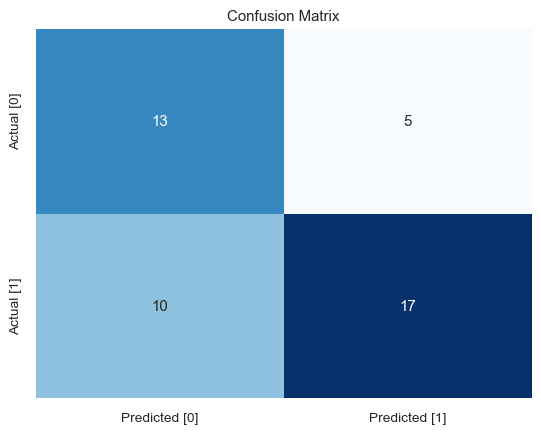

lag: 3, diff: 3
Accuracy: 74.36%
Sensitivity: 0.75
Specificity: 0.74


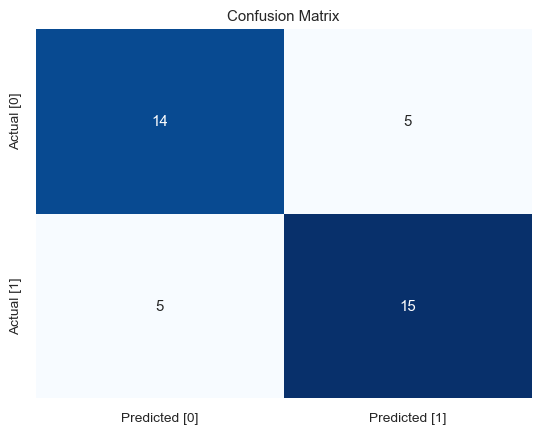

lag: 4, diff: 4
Accuracy: 67.74%
Sensitivity: 0.78
Specificity: 0.54


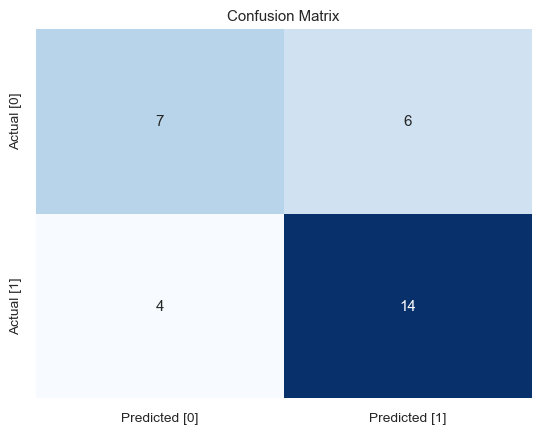

lag: 5, diff: 5
Accuracy: 47.62%
Sensitivity: 0.50
Specificity: 0.45


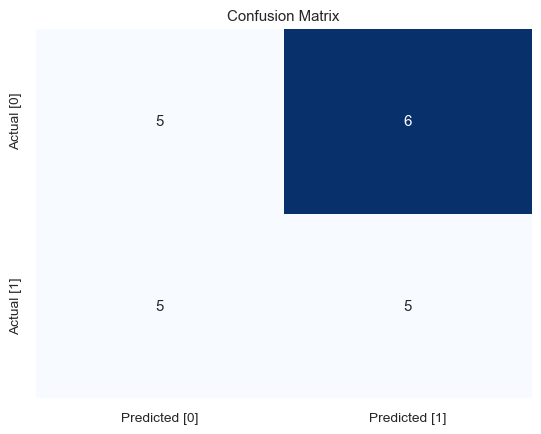

In [42]:
hist = aapl.history(period = '1y')
# # hist = hist.diff()
# hist = hist.diff(periods=15)
# hist = hist.shift(3)
# hist = hist.dropna()
# hist['open_close'] = hist['Close'] - hist['Open']
# hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
# hist['high_low'] = hist['High'] - hist['Low']


# X = hist.drop(['positive'], axis =1)
# y = hist['positive']

# Change n to lag the data
for n in range(1, 6):  
# Data stationary
    hist = hist.diff(periods=n)
    hist = hist.shift(n)
    hist = hist.dropna()

# Add columns
    hist['open_close'] = hist['Close'] - hist['Open']
    hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
    hist['high_low'] = hist['High'] - hist['Low']

# Data partition
    X = hist.drop(['positive'], axis =1)
    y = hist['positive']

    end_train_index = 200
    X_train = X.iloc[:end_train_index]
    X_valid = X.iloc[end_train_index:]

    y_train = y.iloc[:end_train_index]
    y_valid = y.iloc[end_train_index:]

# Model and fitting
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train,y_train)

    logreg_pred = logreg_model.predict(X_valid)
    
# Model Performance    
    logreg_coef = logreg_model.coef_
    logreg_intercept = logreg_model.intercept_

    logreg_accuracy = accuracy_score(y_valid, logreg_pred)
    logreg_cm = confusion_matrix(y_valid, logreg_pred)
    # logreg_classrpt = classification_report(y_valid, logreg_pred)
    tn, fp, fn, tp = logreg_cm.ravel()
    logreg_sensi = tp / (tp + fn)
    logreg_speci = tn / (tn + fp)
    
    print(f'lag: {n}, diff: {n}')
    print(f'Accuracy: {logreg_accuracy:.2%}')
    print(f'Sensitivity: {logreg_sensi:.2f}')
    print(f'Specificity: {logreg_speci:.2f}')

    
# Plot confusion matrix
    sns.set(font_scale=0.9)
    sns.heatmap(logreg_cm, annot=True, cmap='Blues', cbar=False,
            xticklabels=['Predicted [0]', 'Predicted [1]'],
            yticklabels=['Actual [0]', 'Actual [1]'])
    plt.title('Confusion Matrix')
    plt.show()

In [43]:
yf.pdr_override()

y_symbols = ['^GSPC', 'ES=F', 'NQ=F', 'YM=F', '^RUT', '^DJT', '^GDAXI', '^N225', '^SSMI', '^STOXX50E', '^FCHI', '^GSPTSE', '^HSI', '000001.SS', '^KS11', '^NSEI', '^AXJO']
stocks = ['^SPX']

In [44]:
startdate = datetime(2020,3,16)
today = date.today()
enddate = today

In [45]:
stocks

['^SPX']

In [46]:
test = aapl.history(period='1mo')
test?

In [47]:
aapl.get_shares_full(start="2022-01-01", end=None)

In [48]:
opt_df = aapl.option_chain('2023-12-29')
call = opt_df.calls
put = opt_df.puts
put

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY231229P00270000,2023-11-22 21:10:30+00:00,270.0,0.02,0.02,0.02,0.00,0.0,1.0,4257,0.554692,False,REGULAR,USD
1,SPY231229P00275000,2023-11-24 14:50:57+00:00,275.0,0.03,0.02,0.03,0.01,50.0,40.0,0,0.546880,False,REGULAR,USD
2,SPY231229P00280000,2023-11-22 20:41:45+00:00,280.0,0.03,0.02,0.03,0.00,0.0,44.0,0,0.527348,False,REGULAR,USD
3,SPY231229P00285000,2023-11-22 19:02:19+00:00,285.0,0.03,0.02,0.03,0.00,0.0,50.0,0,0.511724,False,REGULAR,USD
4,SPY231229P00290000,2023-11-24 14:30:54+00:00,290.0,0.03,0.02,0.03,0.00,0.0,36.0,3059,0.500005,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,SPY231229P00520000,2023-10-06 19:26:13+00:00,520.0,89.30,84.39,85.46,0.00,0.0,8.0,0,0.757083,True,REGULAR,USD
172,SPY231229P00525000,2023-05-02 14:13:12+00:00,525.0,112.78,0.00,0.00,0.00,0.0,1.0,0,0.000010,True,REGULAR,USD
173,SPY231229P00530000,2023-08-22 19:12:46+00:00,530.0,90.87,98.39,99.27,0.00,0.0,2.0,0,0.881410,True,REGULAR,USD
174,SPY231229P00540000,2023-11-09 18:04:13+00:00,540.0,104.25,83.59,86.45,0.00,0.0,1.0,0,0.372443,True,REGULAR,USD


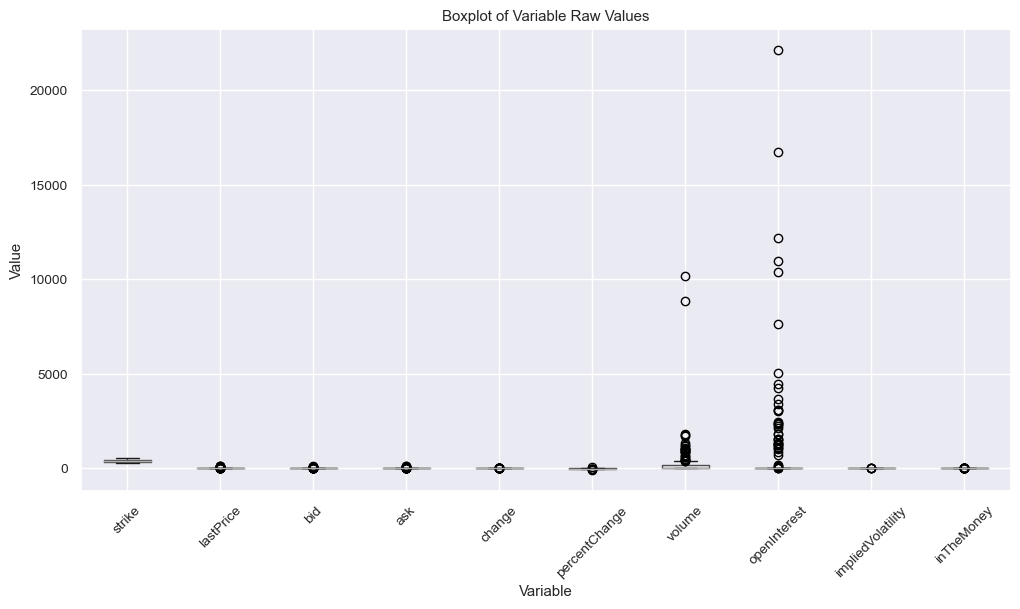

In [49]:
ax = put.boxplot(return_type='axes', rot=45, figsize=(12, 6))
ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Boxplot of Variable Raw Values")
plt.show()

In [50]:
put.describe()

,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,175.000000,176.000000,176.000000
mean,402.000000,7.267727,6.419318,6.697670,-0.086477,-9.234659,281.742857,817.903409,0.262776
std,57.503192,19.432779,17.345077,17.801932,0.195498,12.190052,1055.148090,2687.772522,0.152985
min,270.000000,0.020000,0.000000,0.000000,-1.450001,-80.487800,1.000000,0.000000,0.000010
25%,357.750000,0.130000,0.100000,0.110000,-0.082500,-13.729231,2.000000,0.000000,0.145448
50%,401.500000,0.370000,0.320000,0.330000,-0.030000,-9.815593,20.000000,0.000000,0.239510
75%,445.250000,2.682500,2.477500,2.495000,0.000000,0.000000,150.000000,0.000000,0.343879
max,550.000000,112.780000,98.390000,99.270000,0.280001,50.000000,10163.000000,22140.000000,1.014440


In [51]:
#df_temp

In [52]:
aapl.options

('2023-11-27',
 '2023-11-28',
 '2023-11-29',
 '2023-11-30',
 '2023-12-01',
 '2023-12-08',
 '2023-12-15',
 '2023-12-22',
 '2023-12-29',
 '2024-01-19',
 '2024-02-16',
 '2024-03-15',
 '2024-03-28',
 '2024-06-21',
 '2024-06-28',
 '2024-09-20',
 '2024-09-30',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-12-19',
 '2026-01-16')

## Amazon  - Gabi in progress

In [53]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
amzn.history_metadata

{'currency': 'USD',
 'symbol': 'AMZN',
 'exchangeName': 'NMS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 863703000,
 'regularMarketTime': 1700848801,
 'gmtoffset': -18000,
 'timezone': 'EST',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 146.74,
 'chartPreviousClose': 145.18,
 'previousClose': 146.71,
 'scale': 3,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EST',
   'start': 1700816400,
   'end': 1700836200,
   'gmtoffset': -18000},
  'regular': {'timezone': 'EST',
   'start': 1700836200,
   'end': 1700848800,
   'gmtoffset': -18000},
  'post': {'timezone': 'EST',
   'start': 1700848800,
   'end': 1700874000,
   'gmtoffset': -18000}},
 'tradingPeriods':                                           pre_start                   pre_end  \
 Date                                                                            
 2023-11-20 00:00:00-05:00 2023-11-17 04:00:00-05:00 2023-11-17 09:30:00-05:00   
 2023-11-21 00:00:00-05:00 2023-11-20 04:00:0

In [54]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-11-26 00:00:00-05:00,76.949997,79.240501,76.210999,79.066498,125154000,0.0,0.0
2018-11-27 00:00:00-05:00,78.799500,79.882500,77.900497,79.070999,115664000,0.0,0.0
2018-11-28 00:00:00-05:00,80.695999,84.072502,80.060997,83.887497,169174000,0.0,0.0
2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.0,0.0
2018-11-30 00:00:00-05:00,83.974998,84.800003,83.324997,84.508499,115236000,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-11-17 00:00:00-05:00,142.660004,145.229996,142.539993,145.179993,49636700,0.0,0.0
2023-11-20 00:00:00-05:00,145.130005,146.630005,144.729996,146.130005,41951200,0.0,0.0
2023-11-21 00:00:00-05:00,143.910004,144.050003,141.500000,143.899994,71226000,0.0,0.0
2023-11-22 00:00:00-05:00,144.570007,147.740005,144.570007,146.710007,45669100,0.0,0.0
2023-11-24 00:00:00-05:00,146.699997,147.199997,145.320007,146.740005,22378400,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.0,1258.000000
mean,126.341665,127.904266,124.669430,126.304739,7.785696e+07,0.0,0.015898
std,31.855211,32.138692,31.482601,31.766798,3.534019e+07,0.0,0.563884
min,67.300003,69.801498,65.349998,67.197998,1.762600e+07,0.0,0.000000
25%,94.631124,95.725754,93.500000,94.723627,5.428785e+07,0.0,0.000000
50%,124.945000,126.540001,123.276752,124.863503,6.707655e+07,0.0,0.000000
75%,158.346878,159.930752,156.224998,158.093746,9.219150e+07,0.0,0.000000
max,187.199997,188.654007,184.839493,186.570496,3.113460e+08,0.0,20.000000


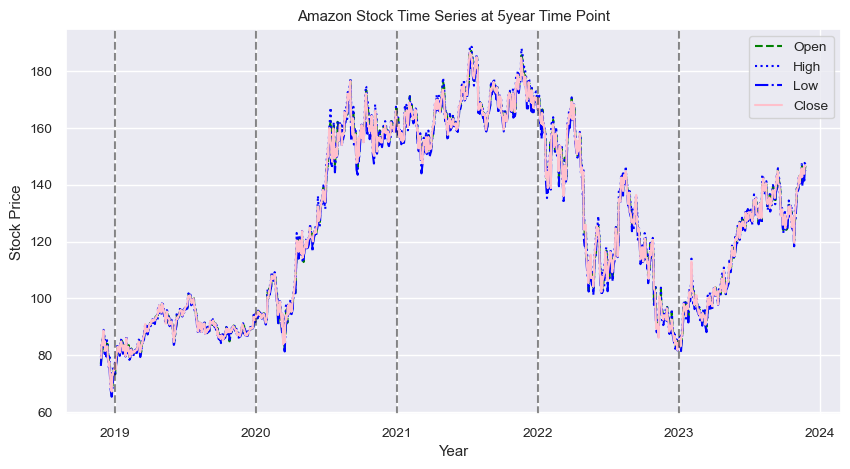

In [55]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# Partition train and validation datasets: 

train = amzn_df.loc['2018-11-09':'2022-12-01']
train = train['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.loc['2022-12-02':'2023-11-08']

In [57]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.544461
p-value: 0.511414
Critical Values:
{'1%': -3.434821532444398, '5%': -2.863514886524506, '10%': -2.5678214111987328}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [58]:
# Fit close stock price dataset to STL: 

stl = STL(amzn_train, period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

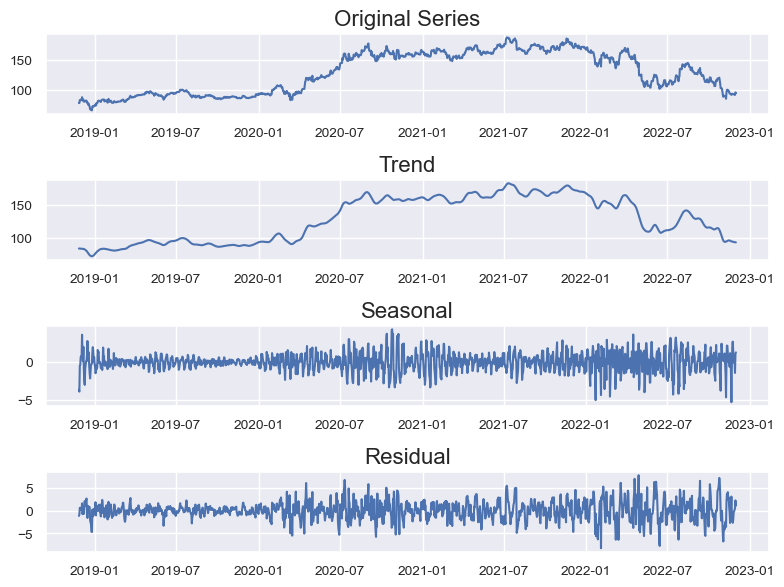

In [59]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt's Winter Smoothing

In [60]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

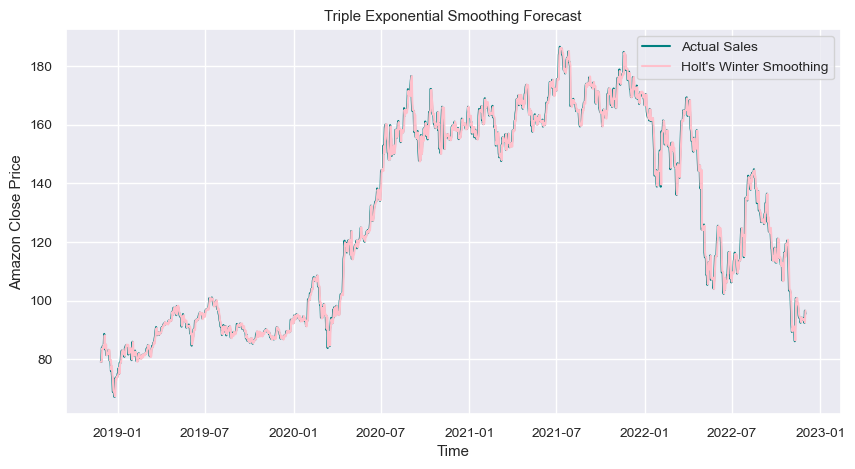

In [61]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection

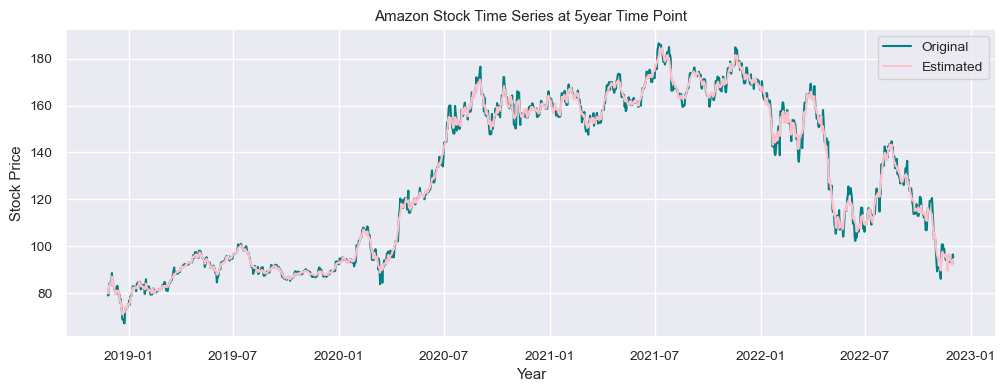

In [62]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(amzn_train, label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(17775.0, 19358.0)

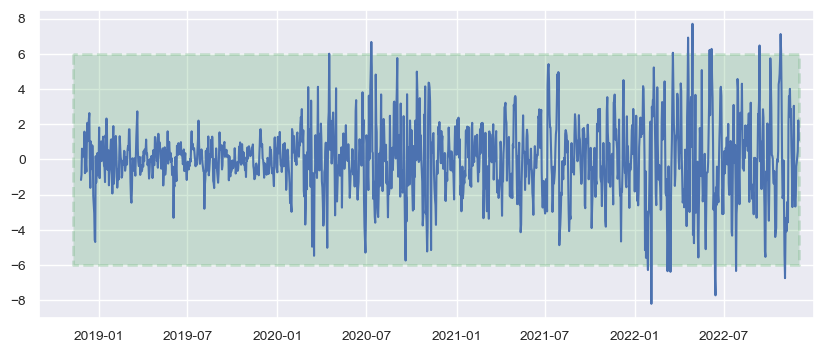

In [64]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,9), datetime(2022,12,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2023,1,1))

In [65]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_train[(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

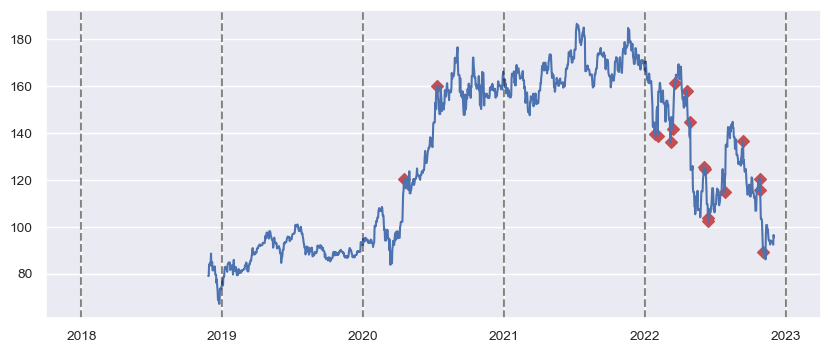

In [66]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_train)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')

In [67]:
# Anomalies identified outside 3std dev of residuals: 

anomalies.head()

,Close
Date,
2020-04-16 00:00:00-04:00,120.409500
2020-07-11 00:00:00-04:00,160.000000
2022-01-27 00:00:00-05:00,139.637497
2022-02-03 00:00:00-05:00,138.845505
2022-03-08 00:00:00-05:00,136.014496


### Transforming Time Series to Stationary

Text(0, 0.5, 'Amazon Stock Closing Price \n(First Diff.)')

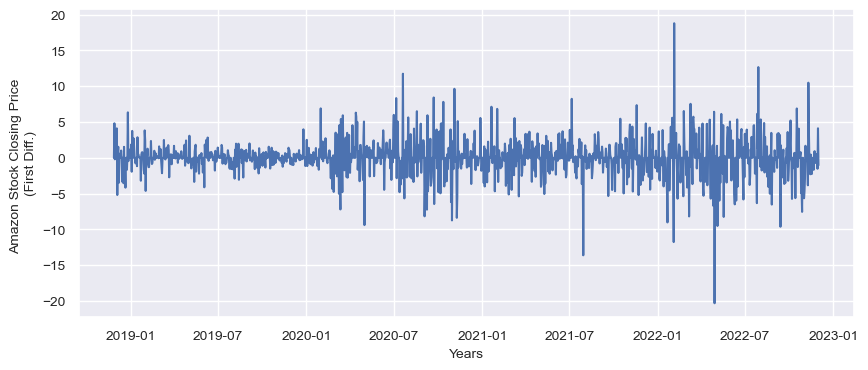

In [68]:
# Removing trend by applying the first Difference: 

diff_ts = amzn_train.diff().dropna()

# Plot first difference: 

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [69]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

ADF Statistic: -40.112198
p-value: 0.000000
Critical Values:
{'1%': -3.434821532444398, '5%': -2.863514886524506, '10%': -2.5678214111987328}
Time series is stationary


### Selecting a Model

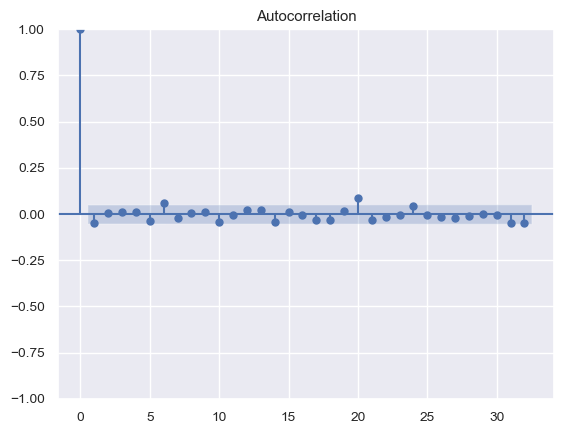

None

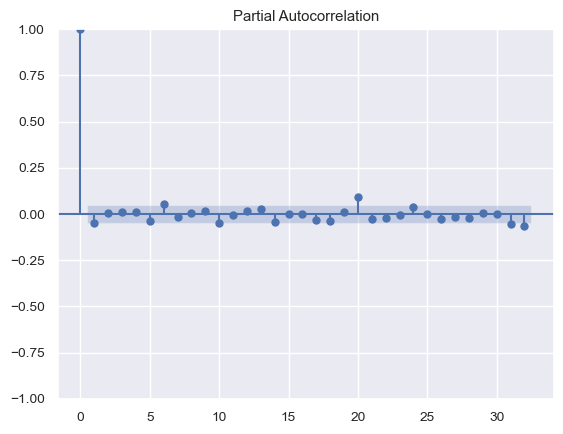

None

In [70]:
# ACF suggest MA Lag 1 

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria: 

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood 
>
>($k$) = a number of parameters 
>
>($n$) = a number of samples used for fitting


In [71]:
# Auto ARIMA Model: 
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

auto_arima_model = auto_arima(diff_ts, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

val_close = valid['Close'].asfreq('D')
arima_pred = auto_arima_model.predict(n_periods=len(val_close))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7848.375, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7374.524, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7846.375, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7188.300, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7088.085, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=7049.600, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=6979.299, Time=0.35 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=6977.300, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=7047.601, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.57 s

In [72]:
# ARIMA Model and Forecast at ARIMA(5,1,0): 

arima_m = sm.tsa.ARIMA(diff_ts, order=(5,1,0)).fit() 
print(arima_m.summary())

arima_pred = arima_m.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1466
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3482.650
Date:                Sat, 25 Nov 2023   AIC                           6977.300
Time:                        10:24:05   BIC                           7009.038
Sample:                    11-27-2018   HQIC                          6989.137
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8790      0.018    -49.635      0.000      -0.914      -0.844
ar.L2         -0.7057      0.025    -28.784      0.000      -0.754      -0.658
ar.L3         -0.5279      0.029    -18.135      0.0

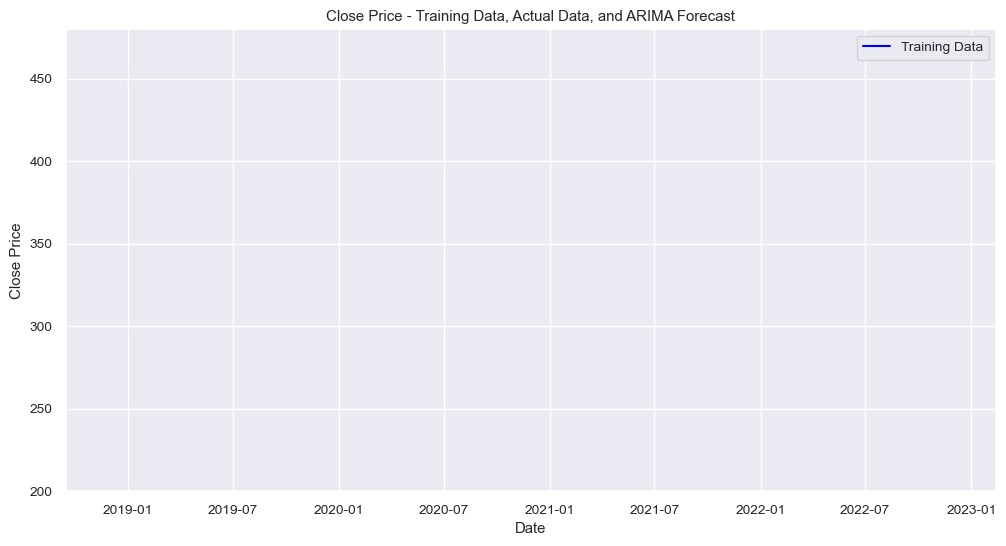

In [73]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')

plt.figure(figsize=(12,6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(diff_ts, label='Training Data', color='blue')
#plt.plot(arima_m.fittedvalues, label="Model", color = 'orange') 
#plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
#plt.plot(val_close.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

###### Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    